In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

from surprise import SVD, NMF, BaselineOnly
from surprise import Dataset, Reader, SVDpp, accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/Datasets/amazon.csv')
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [ ]:
df.head(2)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...


In [ ]:
df = df[['user_id','product_id', 'rating', 'rating_count', 'category', 'product_name', 'img_link', 'about_product']]
df.head(3)

,user_id,product_id,rating,rating_count,category,product_name,img_link,about_product
0,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",B07JW9H4J1,4.2,"24,269",Computers&Accessories|Accessories&Peripherals|...,Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,High Compatibility : Compatible With iPhone 12...
1,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",B098NS6PVG,4.0,"43,994",Computers&Accessories|Accessories&Peripherals|...,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"Compatible with all Type C enabled devices, be..."
2,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...",B096MSW6CT,3.9,"7,928",Computers&Accessories|Accessories&Peripherals|...,Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,【 Fast Charger& Data Sync】-With built-in safet...


In [ ]:
df['about_product']

,about_product
0,High Compatibility : Compatible With iPhone 12...
1,"Compatible with all Type C enabled devices, be..."
2,【 Fast Charger& Data Sync】-With built-in safet...
3,The boAt Deuce USB 300 2 in 1 cable is compati...
4,[CHARGE & SYNC FUNCTION]- This cable comes wit...
...,...
1460,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...
1461,"230 Volts, 400 watts, 1 Year"
1462,International design and styling|Two heat sett...
1463,Fan sweep area: 230 MM ; Noise level: (40 - 45...


In [ ]:
df.shape

(1465, 8)

In [ ]:
#Getting missing values to identify them
df.isnull().sum()

,0
user_id,0
product_id,0
rating,0
rating_count,2
category,0
product_name,0
img_link,0
about_product,0


In [ ]:
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
df.loc[:, 'rating_count'] = df['rating_count'].fillna(0)
df.isnull().sum()

,0
user_id,0
product_id,0
rating,0
rating_count,0
category,0
product_name,0
img_link,0
about_product,0


In [ ]:
df.duplicated().sum()

20

In [ ]:
train_data_cleaned = df.drop_duplicates(subset=['user_id', 'product_id'])
train_data_cleaned.duplicated().sum()

0

In [ ]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'user_id': 'ID',
    'product_id': 'ProdID',
    'rating': 'Rating',
    'rating_count': 'ReviewCount',
    'category': 'Category',
    'product_name': 'Name',
    'img_link': 'ImageURL',
    'about_product': 'Description'
}


# Rename the columns using the mapping
train_data_cleaned.rename(columns=column_name_mapping, inplace=True)

<ipython-input-87-ce22f871f338>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned.rename(columns=column_name_mapping, inplace=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le_id = LabelEncoder()
le_prod = LabelEncoder()

train_data_cleaned['ID']= le_id.fit_transform(train_data_cleaned['ID'])
train_data_cleaned['ProdID'] = le_prod.fit_transform(train_data_cleaned['ProdID'])

<ipython-input-88-f8f70692e5a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['ID']= le_id.fit_transform(train_data_cleaned['ID'])
<ipython-input-88-f8f70692e5a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['ProdID'] = le_prod.fit_transform(train_data_cleaned['ProdID'])


In [ ]:
train_data_cleaned.head()

,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description
0,623,346,4.2,"24,269",Computers&Accessories|Accessories&Peripherals|...,Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,High Compatibility : Compatible With iPhone 12...
1,88,848,4.0,"43,994",Computers&Accessories|Accessories&Peripherals|...,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"Compatible with all Type C enabled devices, be..."
2,849,819,3.9,"7,928",Computers&Accessories|Accessories&Peripherals|...,Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,【 Fast Charger& Data Sync】-With built-in safet...
3,254,643,4.2,"94,363",Computers&Accessories|Accessories&Peripherals|...,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,https://m.media-amazon.com/images/I/41V5FtEWPk...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,17,588,4.2,"16,905",Computers&Accessories|Accessories&Peripherals|...,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,https://m.media-amazon.com/images/W/WEBP_40237...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [ ]:
#Data Cleaning and Tags Creations
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Description']

for column in columns_to_extract_tags_from:
    train_data_cleaned[column] = train_data_cleaned[column].apply(clean_and_extract_tags)

<ipython-input-90-2bbfc23fe875>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned[column] = train_data_cleaned[column].apply(clean_and_extract_tags)


In [ ]:
train_data_cleaned.head()

,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description
0,623,346,4.2,"24,269",Computers&Accessories|Accessories&Peripherals|...,Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,"high, compatibility, compatible, iphone, 12, 1..."
1,88,848,4.0,"43,994",Computers&Accessories|Accessories&Peripherals|...,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"compatible, type, c, enabled, devices, android..."
2,849,819,3.9,"7,928",Computers&Accessories|Accessories&Peripherals|...,Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,"fast, charger, data, built, safety, proctectio..."
3,254,643,4.2,"94,363",Computers&Accessories|Accessories&Peripherals|...,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,https://m.media-amazon.com/images/I/41V5FtEWPk...,"boat, deuce, usb, 300, 2, 1, cable, compatible..."
4,17,588,4.2,"16,905",Computers&Accessories|Accessories&Peripherals|...,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,https://m.media-amazon.com/images/W/WEBP_40237...,"charge, sync, cable, comes, charging, data, sy..."


In [ ]:
# Replace '|' with ',' in the 'Category' column for all records
train_data_cleaned['Category'] = train_data_cleaned['Category'].str.replace('|', ',')

train_data_cleaned.head()

<ipython-input-92-5b1f04b062d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['Category'] = train_data_cleaned['Category'].str.replace('|', ',')


,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description
0,623,346,4.2,"24,269","Computers&Accessories,Accessories&Peripherals,...",Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,"high, compatibility, compatible, iphone, 12, 1..."
1,88,848,4.0,"43,994","Computers&Accessories,Accessories&Peripherals,...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"compatible, type, c, enabled, devices, android..."
2,849,819,3.9,"7,928","Computers&Accessories,Accessories&Peripherals,...",Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,"fast, charger, data, built, safety, proctectio..."
3,254,643,4.2,"94,363","Computers&Accessories,Accessories&Peripherals,...",boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,https://m.media-amazon.com/images/I/41V5FtEWPk...,"boat, deuce, usb, 300, 2, 1, cable, compatible..."
4,17,588,4.2,"16,905","Computers&Accessories,Accessories&Peripherals,...",Portronics Konnect L 1.2M Fast Charging 3A 8 P...,https://m.media-amazon.com/images/W/WEBP_40237...,"charge, sync, cable, comes, charging, data, sy..."


In [ ]:
columns_to_extract_tags = ['Description','Category']

# Concatenate the cleaned tags from all relevant columns
train_data_cleaned['Tags'] = train_data_cleaned[columns_to_extract_tags].apply(lambda row: ', '.join(row), axis=1)

# Convert the 'Rating' column to numeric, forcing errors to NaN
train_data_cleaned['Rating'] = pd.to_numeric(train_data_cleaned['Rating'], errors='coerce')

<ipython-input-93-17295d9a520b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['Tags'] = train_data_cleaned[columns_to_extract_tags].apply(lambda row: ', '.join(row), axis=1)
<ipython-input-93-17295d9a520b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['Rating'] = pd.to_numeric(train_data_cleaned['Rating'], errors='coerce')


In [ ]:
train_data_cleaned = train_data_cleaned.dropna()
print(train_data_cleaned.isnull().sum())

ID             0
ProdID         0
Rating         0
ReviewCount    0
Category       0
Name           0
ImageURL       0
Description    0
Tags           0
dtype: int64


In [ ]:
train_data_cleaned.head()

,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description,Tags
0,623,346,4.2,"24,269","Computers&Accessories,Accessories&Peripherals,...",Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,"high, compatibility, compatible, iphone, 12, 1...","high, compatibility, compatible, iphone, 12, 1..."
1,88,848,4.0,"43,994","Computers&Accessories,Accessories&Peripherals,...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"compatible, type, c, enabled, devices, android...","compatible, type, c, enabled, devices, android..."
2,849,819,3.9,"7,928","Computers&Accessories,Accessories&Peripherals,...",Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,"fast, charger, data, built, safety, proctectio...","fast, charger, data, built, safety, proctectio..."
3,254,643,4.2,"94,363","Computers&Accessories,Accessories&Peripherals,...",boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,https://m.media-amazon.com/images/I/41V5FtEWPk...,"boat, deuce, usb, 300, 2, 1, cable, compatible...","boat, deuce, usb, 300, 2, 1, cable, compatible..."
4,17,588,4.2,"16,905","Computers&Accessories,Accessories&Peripherals,...",Portronics Konnect L 1.2M Fast Charging 3A 8 P...,https://m.media-amazon.com/images/W/WEBP_40237...,"charge, sync, cable, comes, charging, data, sy...","charge, sync, cable, comes, charging, data, sy..."


TfidfVectorizer mengubah teks menjadi representasi numerik berbasis TF-IDF (Term Frequency-Inverse Document Frequency).
TF-IDF menghitung pentingnya sebuah kata dalam dokumen tertentu relatif terhadap seluruh dokumen dalam dataset.
Misalnya, kata yang sering muncul dalam dokumen tertentu tetapi jarang di seluruh dataset akan memiliki nilai TF-IDF yang tinggi.

**Transformasi ke Matriks Sparse:**

fit_transform(train_data_cleaned['Tags']) mengubah data teks menjadi matriks sparse (matriks dengan sebagian besar elemen bernilai nol) di mana:
Baris mewakili dokumen/item.
Kolom mewakili fitur (kata unik dalam seluruh dataset).
Nilai dalam matriks adalah skor TF-IDF untuk kata tersebut dalam dokumen/item.

In [ ]:
#Content Base Recommendation system (User Preferences or Items similarities)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data_cleaned['Tags'])

In [ ]:
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)
cosine_similarities_content

array([[1.        , 0.10860947, 0.16963912, ..., 0.0400941 , 0.03547913,
        0.00410695],
       [0.10860947, 1.        , 0.12711777, ..., 0.        , 0.0130156 ,
        0.02576891],
       [0.16963912, 0.12711777, 1.        , ..., 0.02208449, 0.01864203,
        0.        ],
       ...,
       [0.0400941 , 0.        , 0.02208449, ..., 1.        , 0.13639135,
        0.01648806],
       [0.03547913, 0.0130156 , 0.01864203, ..., 0.13639135, 1.        ,
        0.04881673],
       [0.00410695, 0.02576891, 0.        , ..., 0.01648806, 0.04881673,
        1.        ]])

In [ ]:
def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))
    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Rating']]

    return recommended_items_details

In [ ]:
item_name = 'AmazonBasics Flexible Premium HDMI Cable (Black, 4K@60Hz, 18Gbps), 3-Foot'
item_index = train_data_cleaned[train_data_cleaned['Name']==item_name].index[0]

In [ ]:
 train_data_cleaned[train_data_cleaned['Name']==item_name]

,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description,Tags
12,279,356,4.4,"4,26,973","Electronics,HomeTheater,TV&Video,Accessories,C...",AmazonBasics Flexible Premium HDMI Cable (Blac...,https://m.media-amazon.com/images/I/41nPYaWA+M...,"flexible, lightweight, hdmi, cable, connecting...","flexible, lightweight, hdmi, cable, connecting..."


In [ ]:
item_index

12

In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'Philips Daily Collection HD2582/00 830-Watt 2-Slice Pop-up Toaster (White)'
content_based_rec = content_based_recommendations(train_data_cleaned, item_name, top_n=5)

content_based_rec

,Name,ReviewCount,Rating
1052,INALSA Electric Kettle 1.5 Litre with Stainles...,"8,090",4.1
1125,Wipro Vesta 1.8 litre Cool touch electric Kett...,311,3.8
1169,KENT 16026 Electric Kettle Stainless Steel 1.8...,"2,832",3.9
1048,Lifelong LLEK15 Electric Kettle 1.5L with Stai...,"1,074",3.6
1043,KENT 16052 Elegant Electric Glass Kettle 1.8L ...,"14,030",4.0


**COLLABORATIVE FILTERING (USER-ITEM)**

In [ ]:
# Create the User-Item matrix
user_item_matrix = train_data_cleaned.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)
user_item_matrix

ProdID,0,1,2,3,4,5,6,7,8,9,...,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_item_matrix = train_data_cleaned.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)
user_item_matrix

ProdID,0,1,2,3,4,5,6,7,8,9,...,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
target_user_id = 2
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [ ]:
user_similarities = user_similarity[target_user_index]
user_similarities
similar_user_indices = user_similarities.argsort()[::-1][1:]

In [ ]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data_cleaned[train_data_cleaned['ProdID'].isin(recommend_items)][['Name','ReviewCount','Rating']]

In [ ]:
recommended_items_details.head(10)

,Name,ReviewCount,Rating
46,D-Link DWA-131 300 Mbps Wireless Nano USB Adap...,"8,131",4.1
143,TP-Link Nano USB WiFi Dongle 150Mbps High Gain...,"1,79,692",4.2
148,BlueRigger Digital Optical Audio Toslink Cable...,"30,023",4.2
189,BlueRigger Digital Optical Audio Toslink Cable...,"30,023",4.2
239,Amazon Basics 16-Gauge Speaker Wire - 50 Feet,"12,091",4.4
588,SanDisk Cruzer Blade 32GB USB Flash Drive,"2,53,105",4.3
721,Duracell Plus AAA Rechargeable Batteries (750 ...,"27,201",4.3
724,"Logitech B100 Wired USB Mouse, 3 yr Warranty, ...","31,534",4.3
734,"Logitech M235 Wireless Mouse, 1000 DPI Optical...","54,405",4.5
874,D-Link DIR-615 Wi-fi Ethernet-N300 Single_band...,"22,375",4.1


In [ ]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

        # Get the details of recommended  'ImageURL', 'Rating']]

    return recommended_items_details.head(top_n)


# Example usage
target_user_id = 3
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data_cleaned, target_user_id, top_n)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 3:


,Name,ReviewCount,Rating
46,D-Link DWA-131 300 Mbps Wireless Nano USB Adap...,"8,131",4.1
143,TP-Link Nano USB WiFi Dongle 150Mbps High Gain...,"1,79,692",4.2
148,BlueRigger Digital Optical Audio Toslink Cable...,"30,023",4.2
189,BlueRigger Digital Optical Audio Toslink Cable...,"30,023",4.2
239,Amazon Basics 16-Gauge Speaker Wire - 50 Feet,"12,091",4.4


**Hybrid reccomendation**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def hybrid_filtering_recommendations(train_data, target_user_id, item_name, top_n=10):
    # Step 1: Content-Based Recommendations
    content_recs = content_based_recommendations(train_data, item_name, top_n=top_n)
    content_recs['Content_Score'] = np.linspace(1, 0, len(content_recs))

    # Step 2: Collaborative Filtering Recommendations
    collaborative_recs = collaborative_filtering_recommendations(train_data, target_user_id, top_n=top_n)
    collaborative_recs['Collaborative_Score'] = np.linspace(1, 0, len(collaborative_recs))

    # Step 3: Merge Recommendations
    hybrid_recs = pd.merge(
        content_recs,
        collaborative_recs,
        on='Name',
        how='outer'
    ).fillna(0)  # Fill missing values with 0

    # Step 4: Combine Scores
    scaler = MinMaxScaler()
    hybrid_recs['Hybrid_Score'] = hybrid_recs[['Content_Score', 'Collaborative_Score']].sum(axis=1)
    hybrid_recs['Hybrid_Score'] = scaler.fit_transform(hybrid_recs[['Hybrid_Score']])

    # Step 5: Sort by Hybrid Score
    hybrid_recs = hybrid_recs.sort_values(by='Hybrid_Score', ascending=False)

    # Step 6: Return the Top N Recommendations
    return hybrid_recs.head(top_n)

# Example Usage
target_user_id = 3
item_name = "Philips Daily Collection HD2582/00 830-Watt 2-Slice Pop-up Toaster (White)"
top_n = 5
hybrid_recs = hybrid_filtering_recommendations(train_data_cleaned, target_user_id, item_name, top_n)
print(f"Top {top_n} hybrid recommendations for User {target_user_id}:")
hybrid_recs


Top 5 hybrid recommendations for User 3:


<ipython-input-111-c50ad2375aba>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collaborative_recs['Collaborative_Score'] = np.linspace(1, 0, len(collaborative_recs))


,Name,ReviewCount_x,Rating_x,Content_Score,ReviewCount_y,Rating_y,Collaborative_Score,Hybrid_Score
3,D-Link DWA-131 300 Mbps Wireless Nano USB Adap...,0,0.0,0.00,"8,131",4.1,1.00,1.00
4,INALSA Electric Kettle 1.5 Litre with Stainles...,"8,090",4.1,1.00,0,0.0,0.00,1.00
8,TP-Link Nano USB WiFi Dongle 150Mbps High Gain...,0,0.0,0.00,"1,79,692",4.2,0.75,0.75
9,Wipro Vesta 1.8 litre Cool touch electric Kett...,311,3.8,0.75,0,0.0,0.00,0.75
1,BlueRigger Digital Optical Audio Toslink Cable...,0,0.0,0.00,"30,023",4.2,0.50,0.50


In [ ]:
!pip install scikit-surprise

In [ ]:
train_data_cleaned

,ID,ProdID,Rating,ReviewCount,Category,Name,ImageURL,Description,Tags
0,623,346,4.2,"24,269","Computers&Accessories,Accessories&Peripherals,...",Wayona Nylon Braided USB to Lightning Fast Cha...,https://m.media-amazon.com/images/W/WEBP_40237...,"high, compatibility, compatible, iphone, 12, 1...","high, compatibility, compatible, iphone, 12, 1..."
1,88,848,4.0,"43,994","Computers&Accessories,Accessories&Peripherals,...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,https://m.media-amazon.com/images/W/WEBP_40237...,"compatible, type, c, enabled, devices, android...","compatible, type, c, enabled, devices, android..."
2,849,819,3.9,"7,928","Computers&Accessories,Accessories&Peripherals,...",Sounce Fast Phone Charging Cable & Data Sync U...,https://m.media-amazon.com/images/W/WEBP_40237...,"fast, charger, data, built, safety, proctectio...","fast, charger, data, built, safety, proctectio..."
3,254,643,4.2,"94,363","Computers&Accessories,Accessories&Peripherals,...",boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,https://m.media-amazon.com/images/I/41V5FtEWPk...,"boat, deuce, usb, 300, 2, 1, cable, compatible...","boat, deuce, usb, 300, 2, 1, cable, compatible..."
4,17,588,4.2,"16,905","Computers&Accessories,Accessories&Peripherals,...",Portronics Konnect L 1.2M Fast Charging 3A 8 P...,https://m.media-amazon.com/images/W/WEBP_40237...,"charge, sync, cable, comes, charging, data, sy...","charge, sync, cable, comes, charging, data, sy..."
...,...,...,...,...,...,...,...,...,...
1460,1050,673,4.0,"1,090","Home&Kitchen,Kitchen&HomeAppliances,WaterPurif...",Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,https://m.media-amazon.com/images/I/41fDdRtjfx...,"supreme, quality, 90, gram, 3, layer, thik, pp...","supreme, quality, 90, gram, 3, layer, thik, pp..."
1461,425,201,4.1,"4,118","Home&Kitchen,Kitchen&HomeAppliances,SmallKitch...",Prestige Delight PRWO Electric Rice Cooker (1 ...,https://m.media-amazon.com/images/I/41gzDxk4+k...,"230, volts, 400, watts, 1, year","230, volts, 400, watts, 1, year, Home&Kitchen,..."
1462,865,27,3.6,468,"Home&Kitchen,Heating,Cooling&AirQuality,RoomHe...",Bajaj Majesty RX10 2000 Watts Heat Convector R...,https://m.media-amazon.com/images/W/WEBP_40237...,"international, design, heat, settings, 1000, w...","international, design, heat, settings, 1000, w..."
1463,300,61,4.0,"8,031","Home&Kitchen,Heating,Cooling&AirQuality,Fans,E...",Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,https://m.media-amazon.com/images/W/WEBP_40237...,"fan, sweep, area, 230, mm, noise, level, 40, 4...","fan, sweep, area, 230, mm, noise, level, 40, 4..."


In [ ]:
def svd_recommendations(data, target_user_id, top_n=10):
    # Step 1: Load the data into the Surprise library's format
    reader = Dataset.load_from_df(data[['ID', 'ProdID', 'Rating']], reader=Reader(rating_scale=(1, 5)))

    # Step 2: Split the data into training and testing datasets
    trainset, testset = train_test_split(reader, test_size=0.2, random_state=42)

    # Step 3: Train the SVD algorithm
    svd = SVD(random_state=42)
    svd.fit(trainset)

    # Step 4: Make predictions
    predictions = svd.test(testset)

    # Step 5: Evaluate RMSE and MAE
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Step 6: Predict for target user
    user_ratings = data[data['ID'] == target_user_id]
    all_prod_ids = data['ProdID'].unique()
    rated_prods = user_ratings['ProdID'].tolist()

    # Find unrated products
    unrated_prods = [prod for prod in all_prod_ids if prod not in rated_prods]

    # Predict ratings for unrated products
    recommendations = []tsh
    for prod_id in unrated_prods:
        pred = svd.predict(target_user_id, prod_id)
        recommendations.append((prod_id, pred.est))

    # Sort by estimated rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]

    # Create a DataFrame for recommendations
    recommended_df = pd.DataFrame(recommendations, columns=['ProdID', 'EstimatedRating'])
    recommended_df = pd.merge(recommended_df, data[['ProdID', 'Rating', 'Name']].drop_duplicates(), on='ProdID')

    return recommended_df, rmse, mae

# Example Usage
target_user_id = 5

recommendations, rmse, mae = svd_recommendations(train_data_cleaned, target_user_id, top_n)

print(f"Top {top_n} recommendations for User {target_user_id}:")
print(recommendations)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 0.2661
MAE:  0.2143
Top 5 recommendations for User 5:
   ProdID  EstimatedRating  Rating  \
0    1125         4.410149     4.1   
1    1309         4.390130     4.1   
2      70         4.379275     4.5   
3     536         4.373108     4.5   
4     462         4.370107     4.0   

                                                Name  
0  TCL 80 cm (32 inches) HD Ready Certified Andro...  
1  Portronics Key2 Combo Multimedia USB Wireless ...  
2  Luxor 5 Subject Single Ruled Notebook - A4, 70...  
3  Casio FX-991ES Plus-2nd Edition Scientific Cal...  
4  Lifelong LLWH106 Flash 3 Litres Instant Water ...  
RMSE: 0.2661, MAE: 0.2143


In [ ]:
def NMF_recommendations(data, target_user_id, top_n=10):
    # Load the data into Surprise dataset format
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(data[['ID', 'ProdID', 'Rating']], reader)

    # Split the data into training and testing datasets
    trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

    # Train the SVD algorithm
    model = NMF(random_state=42)
    model.fit(trainset)

    # Make predictions
    predictions = model.test(testset)

    # Evaluate RMSE and MAE on the testset
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Perform cross-validation and capture the results
    cv_results = cross_validate(model, dataset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    cv_rmse = cv_results['test_rmse']
    cv_mae = cv_results['test_mae']

    # Aggregate cross-validation results
    avg_rmse = sum(cv_rmse) / len(cv_rmse)
    avg_mae = sum(cv_mae) / len(cv_mae)

    print("Cross-Validation Results:")
    print(f"RMSE per fold: {cv_rmse}")
    print(f"MAE per fold: {cv_mae}")
    print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

    # Predict for the target user
    user_ratings = data[data['ID'] == target_user_id]
    all_prod_ids = data['ProdID'].unique()
    rated_prods = user_ratings['ProdID'].tolist()

    # Find unrated products
    unrated_prods = [prod for prod in all_prod_ids if prod not in rated_prods]

    # Predict ratings for unrated products
    recommendations = []
    for prod_id in unrated_prods:
        pred = model.predict(target_user_id, prod_id)
        recommendations.append((prod_id, pred.est))

    # Sort by estimated rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]

    # Create a DataFrame for recommendations
    recommended_df = pd.DataFrame(recommendations, columns=['ProdID', 'EstimatedRating'])
    recommended_df = pd.merge(recommended_df, data[['ProdID', 'Rating', 'Name']].drop_duplicates(), on='ProdID')

    return recommended_df, rmse, mae, avg_rmse, avg_mae

# Example Usage
target_user_id = 5
top_n = 10
recommendations, rmse, mae, avg_rmse, avg_mae = NMF_recommendations(train_data_cleaned, target_user_id, top_n)

print(f"Top {top_n} recommendations for User {target_user_id}:")
print(recommendations)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")
print(f"Cross-Validation Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

RMSE: 0.2747
MAE:  0.2209
Cross-Validation Results:
RMSE per fold: [0.27019667 0.29880714 0.33426418]
MAE per fold: [0.21201049 0.21685394 0.23394294]
Average RMSE: 0.3011, Average MAE: 0.2209
Top 10 recommendations for User 5:
   ProdID  EstimatedRating  Rating  \
0     346         4.097244     4.2   
1     848         4.097244     4.0   
2     819         4.097244     3.9   
3     643         4.097244     4.2   
4     588         4.097244     4.2   
5     771         4.097244     3.9   
6     761         4.097244     4.1   
7     614         4.097244     4.3   
8      15         4.097244     4.2   
9     515         4.097244     4.0   

                                                Name  
0  Wayona Nylon Braided USB to Lightning Fast Cha...  
1  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...  
2  Sounce Fast Phone Charging Cable & Data Sync U...  
3  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...  
4  Portronics Konnect L 1.2M Fast Charging 3A 8 P...  
5  pTron Solero TB301 3

In [ ]:
def SVDpp_recommendations(data, target_user_id, top_n=10):
    # Load the data into Surprise dataset format
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(data[['ID', 'ProdID', 'Rating']], reader)

    # Split the data into training and testing datasets
    trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

    # Train the SVD algorithm
    model = SVDpp(random_state=42)
    model.fit(trainset)

    # Make predictions
    predictions = model.test(testset)

    # Evaluate RMSE and MAE on the testset
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Perform cross-validation and capture the results
    cv_results = cross_validate(model, dataset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    cv_rmse = cv_results['test_rmse']
    cv_mae = cv_results['test_mae']

    # Aggregate cross-validation results
    avg_rmse = sum(cv_rmse) / len(cv_rmse)
    avg_mae = sum(cv_mae) / len(cv_mae)

    print("Cross-Validation Results:")
    print(f"RMSE per fold: {cv_rmse}")
    print(f"MAE per fold: {cv_mae}")
    print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

    # Predict for the target user
    user_ratings = data[data['ID'] == target_user_id]
    all_prod_ids = data['ProdID'].unique()
    rated_prods = user_ratings['ProdID'].tolist()

    # Find unrated products
    unrated_prods = [prod for prod in all_prod_ids if prod not in rated_prods]

    # Predict ratings for unrated products
    recommendations = []
    for prod_id in unrated_prods:
        pred = model.predict(target_user_id, prod_id)
        recommendations.append((prod_id, pred.est))

    # Sort by estimated rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]

    # Create a DataFrame for recommendations
    recommended_df = pd.DataFrame(recommendations, columns=['ProdID', 'EstimatedRating'])
    recommended_df = pd.merge(recommended_df, data[['ProdID', 'Rating', 'Name']].drop_duplicates(), on='ProdID')

    return recommended_df, rmse, mae, avg_rmse, avg_mae

# Example Usage
target_user_id = 5
top_n = 10
recommendations, rmse, mae, avg_rmse, avg_mae = SVDpp_recommendations(train_data_cleaned, target_user_id, top_n)

print(f"Top {top_n} recommendations for User {target_user_id}:")
print(recommendations)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")
print(f"Cross-Validation Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

RMSE: 0.2656
MAE:  0.2137
Cross-Validation Results:
RMSE per fold: [0.27797234 0.28978574 0.31320568]
MAE per fold: [0.21140505 0.20525732 0.22392466]
Average RMSE: 0.2937, Average MAE: 0.2135
Top 10 recommendations for User 5:
   ProdID  EstimatedRating  Rating  \
0    1342         4.289009     5.0   
1     205         4.278125     4.6   
2    1205         4.275412     4.8   
3     221         4.263624     4.2   
4     733         4.256350     4.0   
5     407         4.252846     4.4   
6    1321         4.251879     4.7   
7    1148         4.247608     4.3   
8     111         4.247310     4.6   
9      43         4.242086     4.3   

                                                Name  
0  Syncwire LTG to USB Cable for Fast Charging Co...  
1  Logitech M331 Silent Plus Wireless Mouse, 2.4G...  
2  Instant Pot Air Fryer, Vortex 2QT, Touch Contr...  
3  Pigeon by Stovekraft 2 Slice Auto Pop up Toast...  
4  PHILIPS Handheld Garment Steamer STH3000/20 - ...  
5  SLOVIC® Tripod Mount

In [ ]:
def Baseline_recommendations(data, target_user_id, top_n=10):
    # Load the data into Surprise dataset format
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(data[['ID', 'ProdID', 'Rating']], reader)

    # Split the data into training and testing datasets
    trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

    # Train the SVD algorithm
    model = BaselineOnly()
    model.fit(trainset)

    # Make predictions
    predictions = model.test(testset)

    # Evaluate RMSE and MAE on the testset
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Perform cross-validation and capture the results
    cv_results = cross_validate(model, dataset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    cv_rmse = cv_results['test_rmse']
    cv_mae = cv_results['test_mae']

    # Aggregate cross-validation results
    avg_rmse = sum(cv_rmse) / len(cv_rmse)
    avg_mae = sum(cv_mae) / len(cv_mae)

    print("Cross-Validation Results:")
    print(f"RMSE per fold: {cv_rmse}")
    print(f"MAE per fold: {cv_mae}")
    print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

    # Predict for the target user
    user_ratings = data[data['ID'] == target_user_id]
    all_prod_ids = data['ProdID'].unique()
    rated_prods = user_ratings['ProdID'].tolist()

    # Find unrated products
    unrated_prods = [prod for prod in all_prod_ids if prod not in rated_prods]

    # Predict ratings for unrated products
    recommendations = []
    for prod_id in unrated_prods:
        pred = model.predict(target_user_id, prod_id)
        recommendations.append((prod_id, pred.est))

    # Sort by estimated rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]

    # Create a DataFrame for recommendations
    recommended_df = pd.DataFrame(recommendations, columns=['ProdID', 'EstimatedRating'])
    recommended_df = pd.merge(recommended_df, data[['ProdID', 'Rating', 'Name']].drop_duplicates(), on='ProdID')

    return recommended_df, rmse, mae, avg_rmse, avg_mae

# Example Usage
target_user_id = 5
top_n = 10
recommendations, rmse, mae, avg_rmse, avg_mae = Baseline_recommendations(train_data_cleaned, target_user_id, top_n)

print(f"Top {top_n} recommendations for User {target_user_id}:")
print(recommendations)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")
print(f"Cross-Validation Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")

Estimating biases using als...
RMSE: 0.2673
MAE:  0.2157
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Cross-Validation Results:
RMSE per fold: [0.28576761 0.2945752  0.30472288]
MAE per fold: [0.20843737 0.22330869 0.21477437]
Average RMSE: 0.2950, Average MAE: 0.2155
Top 10 recommendations for User 5:
   ProdID  EstimatedRating  Rating  \
0    1342         4.175026     5.0   
1    1349         4.175026     5.0   
2    1121         4.175026     5.0   
3    1205         4.157883     4.8   
4    1145         4.149312     4.7   
5    1320         4.149312     4.7   
6    1343         4.149312     4.7   
7     732         4.140740     4.6   
8     816         4.140740     4.6   
9     182         4.140740     4.6   

                                                Name  
0  Syncwire LTG to USB Cable for Fast Charging Co...  
1  REDTECH USB-C to Lightning Cable 3.3FT, [Apple...  
2  Amazon Basics Wireless Mouse | 2.4 GHz Connect...  
3  Instan

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
      Algorithm  Test RMSE  Test MAE  Cross-Validation RMSE  \
0           SVD   0.266145  0.214277               0.294093   
1           NMF   0.274676  0.220900               0.302007   
2         SVDpp   0.265555  0.213721               0.292927   
3  BaselineOnly   0.267291  0.215657               0.294924   

   Cross-Validation MAE  Test Time (s)  
0              0.214804       0.147761  
1              0.220112       0.517285  
2              0.213389       0.035164  
3              0.215583       0.032783  


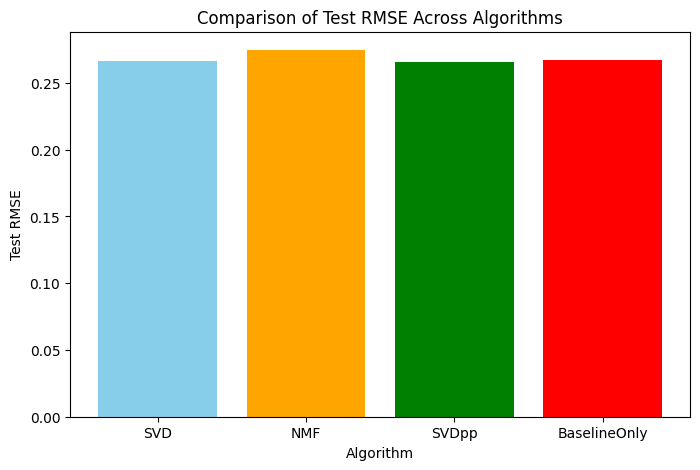

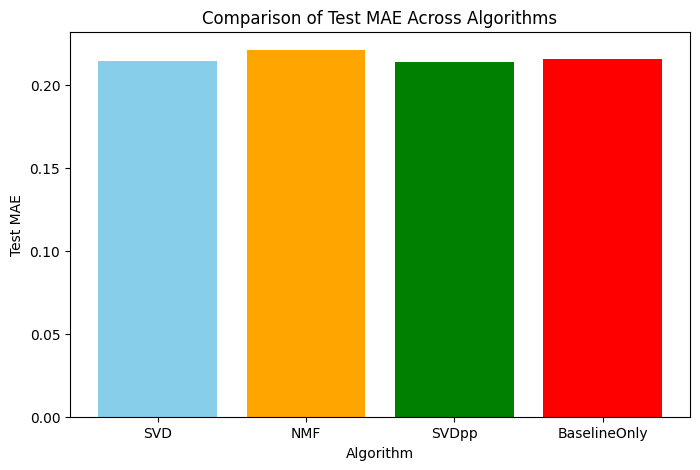

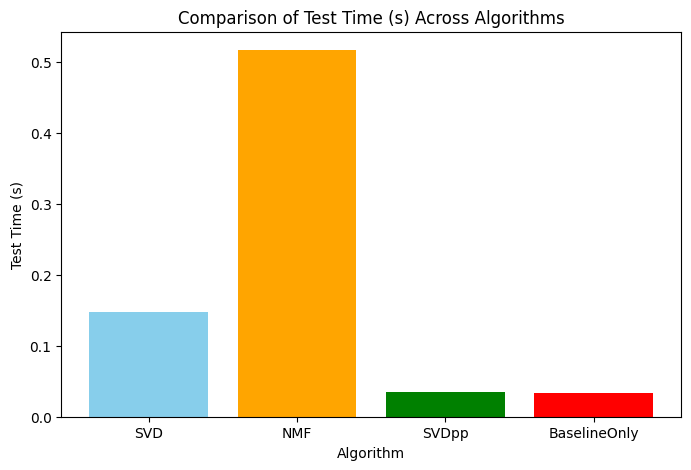

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, NMF, SVDpp, BaselineOnly, accuracy
from surprise.model_selection import train_test_split, cross_validate
import time

def evaluate_models(data, target_user_id):
    algorithms = {
        "SVD": SVD(random_state=42),
        "NMF": NMF(random_state=42),
        "SVDpp": SVDpp(random_state=42),
        "BaselineOnly": BaselineOnly(),
    }

    results = []

    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(data[['ID', 'ProdID', 'Rating']], reader)
    trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

    for name, algorithm in algorithms.items():
        start_time = time.time()
        algorithm.fit(trainset)
        predictions = algorithm.test(testset)
        test_time = time.time() - start_time

        # Calculate metrics
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        cv_results = cross_validate(algorithm, dataset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
        avg_rmse = cv_results['test_rmse'].mean()
        avg_mae = cv_results['test_mae'].mean()

        results.append({
            "Algorithm": name,
            "Test RMSE": rmse,
            "Test MAE": mae,
            "Cross-Validation RMSE": avg_rmse,
            "Cross-Validation MAE": avg_mae,
            "Test Time (s)": test_time
        })

    return pd.DataFrame(results)

# Evaluate models
results_df = evaluate_models(train_data_cleaned, target_user_id)

# Display results
print(results_df)

# Visualization
metrics = ["Test RMSE", "Test MAE", "Test Time (s)"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df["Algorithm"], results_df[metric], color=['skyblue', 'orange', 'green', 'red'])
    plt.title(f"Comparison of {metric} Across Algorithms")
    plt.xlabel("Algorithm")
    plt.ylabel(metric)
    plt.show()
